In [1]:
%matplotlib inline

Construction de la courbe des taux EURIBOR.
======


Je vais ici réaliser un prototype de calage de la courbe des taux.
Cette implémentation ne dépend d'aucune autre librairie à l'exception de la fonction d'interpolation de courbe.

Tout d'abord nous créons **CurveSimple**. 
Cette courbe permet à partir de taux zéro coupons de calculer la quote des produits dérivés vanilles:

* Le Money Market : **MM($\bf{t}$)**
* Le Future : **Fut($\bf{t_1}$,$\bf{t_2}$)**
* Le Swap : **Swap($\bf{t}$)**

Pour construire la courbe de taux, le seul paramètre indispensable est date de valeur: **asofdate**.

In [2]:
from scipy import interpolate
from math import exp
from datetime import datetime
import numpy as np
import bisect

# Courbe des taux
class CurveSimple:
    def __init__(self,asofdate,spline=False,t = [], rates = [], plots = []):
        self.t = t
        self.asofdate = asofdate
        self.spline = spline
        self.t = t
        self.rates = rates
        self.plots = plots
        self.Update()
    
    # Le facteur d'actualisation en base A365
    def df(self, t):
        if len(self.t) > 1:
            return exp(-self.F(t)*t)
        else:
            return exp(-self.rates[0]*t)
    
    def zcrate(self,t):
        return self.F(t)
    
    # Le forward de taux en base A360
    def fwd(self,t1,t2):
        return (self.df(t1)/self.df(t2)-1.0)/(t2-t1)*360/365
    
    # Le money Market
    def MM(self,t):
        return self.fwd(2.0/365,2.0/365+t)
    
    # Le Future
    def Fut(self,t1,t2):
        return 100-self.fwd(t1,t2)*100
    
    # L'annuité (fréquence annuelle, base 30/360)
    def Annuity(self,t):
        price = 0
        for t in np.arange(0,t,1):
            price = price + self.df(2.0/365+t+1)
        return price
    
    # La jambe variable
    def VarLeg(self,t):
        return self.df(2.0/365) - self.df(2.0/365+t)
    
    # Le taux de swap
    def Swap(self,t):
        return self.VarLeg(t)/self.Annuity(t)
    
    # Ajoute ou met à jour un nouveau point de la courbe
    def Update(self,t = 0,rate = 0):
        if t !=0:
            if len(self.t) > 0:
                pos = bisect.bisect(self.t,t)
                if self.t[pos-1] != t:
                    self.t.insert(pos,t)
                    self.rates.insert(pos,rate)
                else:
                    self.rates[pos-1] = rate
            else:
                self.t = [t]
                self.rates = [rate]
    
        # l'interpolation fonctionne avec au moins 2 points
        if len(self.t) > 1:
            # Il faut minimum 4 points pour que le spline fonctionne
            if len(self.t) < 4 or not self.spline:
                self.F = interpolate.interp1d(self.t,self.rates,kind='linear')
            elif len(self.t) >= 4: 
                self.F = interpolate.InterpolatedUnivariateSpline(self.t,self.rates)

La classe **Curve** est une extension de **CurveSimple**. Elle intègre l'agorithme de Bootstrap.

L'introduction d'une méthode **Quote(plot)** permet de calculer de façon synthétique la valeur des produits dérivés qui serviront ensuite à caler la courbe.

La méthode **CalibrateQuote(plot,quote)** cale numeriquement un taux zéro coupon afin de reproduire la quote du produit dérivé.
La méthode **Calibrate(plot_quotes)** cale successivement tous les plots de la courbe

In [3]:
from datetime import date,timedelta,datetime
from dateutil.relativedelta import relativedelta
import math

# Calcul les dates IMM: le 3ème mercredi du mois.
def IMM(plot):
    month_dico = {"MAR" : 3, "JUN" : 6, "SEP" : 9, "DEC" : 12}
    imm_date = date(2000+int(plot[3:]),month_dico[plot[:3]],1)
    wednesday_count = 0
    while True:
        if imm_date.weekday() == 2:
            wednesday_count+=1
        if wednesday_count == 3:
            return imm_date
        imm_date += timedelta(days=1)
        
# Calcul de la prochaine date IMM
def IMMNext(plot):
    imm_next_date = IMM(plot)
    imm_next_date += relativedelta(months=3)
    imm_next_date = imm_next_date.replace(day=1)
    wednesday_count = 0
    while True:
        if imm_next_date.weekday() == 2:
            wednesday_count+=1
        if wednesday_count == 3:
            return imm_next_date
        imm_next_date += timedelta(days=1)

class Curve(CurveSimple): 

    # Calcul la quote d'un plot de la courbe
    def Quote(self,plot):
        if plot == "2D":
            return (exp(2.0/365*self.rates[0])-1)*360.0/2.0
        elif plot[-1] == 'M':
            return self.MM(float(plot[:len(plot)-1])/12.0)
        elif plot[:3] in ('MAR','JUN','SEP','DEC'):
            return self.Fut(float((IMM(plot)-self.asofdate).days)/365,float((IMMNext(plot)-self.asofdate).days)/365)
        elif plot[-1] == "Y":
            return self.Swap(float(plot[:len(plot)-1]))
    
    #calcul le prix d'un plot (utilisée pour calculer les quantités requises)
    def Price(self,plot,quote):
        if plot == "2D":
            return exp(2.0/365*self.rates[0])
        elif plot[-1] == 'M':
            return self.MM(float(plot[:len(plot)-1])/12.0)*self.df(self.PlotTime(plot))
        elif plot[:3] in ('MAR','JUN','SEP','DEC'):
            return self.Fut(float((IMM(plot)-self.asofdate).days)/365,float((IMMNext(plot)-self.asofdate).days)/365)*0.25
        elif plot[-1] == "Y":
            return (quote-self.Swap(float(plot[:len(plot)-1])))*self.Annuity(float(plot[:len(plot)-1]))
        
    
    # Calcule la date associé à un plot
    def PlotTime(self, plot):
        if plot == "2D":
            return 2.0/365
        elif plot[-1] == 'M':
            return 2.0/365+float(plot[:len(plot)-1])/12
        elif plot[:3] in ('MAR','JUN','SEP','DEC'):
            return 2.0/365+float((IMMNext(plot)-self.asofdate).days)/365
        elif plot[-1] == "Y":
            return 2.0/365+float(plot[:len(plot)-1])
    
    # Calibre la courbe à partir de la quote d'un instrument
    def CalibratePlot(self,plot,quote):
        # Enregistre le plots calibré
        if plot not in self.plots:
            self.plots += [plot]
        if plot == "2D":
           rate = math.log(1+2.0/360*quote)/2.0*365
           self.Update(2.0/365.0,rate) 
        else:
            rate = 0.05
            eps = 1e-10
            for i in range(10):
                self.Update(self.PlotTime(plot),rate)
                value = self.Quote(plot)
                if abs(value-quote) < eps:
                    return
                self.Update(self.PlotTime(plot),rate+eps)
                deriv = (self.Quote(plot)-value)/eps
                rate = rate - (value-quote)/deriv
                
    # Calibre la courbe à partir de la quote d'une liste d'instruments
    def Calibrate(self,plot_quotes):
        # Dans le cas du spline on reitère 5 fois l'algorithme
        self.plots = []
        if self.spline:
            nbiters=3
        else:
            nbiters=1
        for it in range(nbiters):
            for pq in plot_quotes:
                self.CalibratePlot(pq[0],pq[1])
                
    # retourne les taux de marché de la courbe        
    def mkt_curve(self):
        return [ (self.plots[i],round(self.Quote(self.plots[i]),4)) for i in range(len(self.plots)) ]
                
    # retourne les taux zc de la courbe        
    def zc_curve(self):
        return [ (self.plots[i],round(self.rates[i],5)) for i in range(len(self.plots)) ]

Exemple de calage de courbe des taux
=====

Ces données sont seulement vraissemblables ...

Date de valeur : **29 Janvier 2016.**

<table>
<tr>
<th>type</th>
<th align="right"><b>Plot</b></th>
<th><b>Quote</b></th>
</tr>
<tr>
<td>MM</td>
<td align="right">2D</td>
<td>-0.23%</td>
</tr>
<tr>
<td>MM</td>
<td align="right">1M</td>
<td>-0.23%</td>
</tr>
<tr>
<td>MM</td>
<td align="right">3M</td>
<td>-0.16%</td>
</tr>
<tr>
<td>MM</td>
<td align="right">6M</td>
<td>-0.10%</td>
</tr>
<tr>
<td>MM</td>
<td align="right">12M</td>
<td>-0.10%</td>
</tr>
<tr>
<td>SWAP</td>
<td align="right">2Y</td>
<td>0.11%</td>
</tr>
<tr>
<td>SWAP</td>
<td align="right">3Y</td>
<td>-0.12%</td>
</tr>
<tr>
<td>SWAP</td>
<td align="right">4Y</td>
<td>-0.03%</td>
</tr>
<tr>
<td>SWAP</td>
<td align="right">5Y</td>
<td>0.08%</td>
</tr>
<tr>
<td>SWAP</td>
<td align="right">7Y</td>
<td>0.33%</td>
</tr>
<tr>
<td>SWAP</td>
<td align="right">10Y</td>
<td>0.68%</td>
</tr>
<tr>
<td>SWAP</td>
<td align="right">12Y</td>
<td>0.87%</td>
</tr>
<tr>
<td>SWAP</td>
<td align="right">15Y</td>
<td>1.07%</td>
</tr>
<tr>
<td>SWAP</td>
<td align="right">20Y</td>
<td>1.22%</td>
</tr>
<tr>
<tr>
<td>SWAP</td>
<td align="right">25Y</td>
<td>1.27%</td>
</tr>
<tr>
<td>SWAP</td>
<td align="right">30Y</td>
<td>1.28%</td>
</tr>
</table>

On vérifie ensuite les résultats du calage.

In [4]:
AsOfDate = date(2016,1,29)
curve = Curve(AsOfDate,False)
curvespline = Curve(AsOfDate,True)

quote_rates = [
 ('2D', -0.0023),
 ('1M', -0.0023),
 ('3M', -0.0016),
 ('6M', -0.001),
 ('12M',-0.0009),
 ('2Y', -0.0011),
 ('3Y', -0.0012),
 ('4Y', -0.0003),
 ('5Y', 0.0008),
 ('7Y', 0.0033),
 ('10Y', 0.0068),
 ('12Y', 0.0087),
 ('15Y', 0.0107),
 ('20Y', 0.0122),
 ('25Y', 0.0127),
 ('30Y', 0.0128)]

curve.Calibrate(quote_rates)
curvespline.Calibrate(quote_rates)
([(qr[0],'%1.8f%%'%(100*abs(qr[1]-curve.Quote(qr[0])))) for qr in quote_rates],
 [(qr[0],'%1.8f%%'%(100*abs(qr[1]-curvespline.Quote(qr[0])))) for qr in quote_rates])

([('2D', '0.00000000%'),
  ('1M', '0.00000000%'),
  ('3M', '0.00000000%'),
  ('6M', '0.00000000%'),
  ('12M', '0.00000000%'),
  ('2Y', '0.00000000%'),
  ('3Y', '0.00000000%'),
  ('4Y', '0.00000001%'),
  ('5Y', '0.00000000%'),
  ('7Y', '0.00000000%'),
  ('10Y', '0.00000000%'),
  ('12Y', '0.00000000%'),
  ('15Y', '0.00000000%'),
  ('20Y', '0.00000000%'),
  ('25Y', '0.00000000%'),
  ('30Y', '0.00000001%')],
 [('2D', '0.00000000%'),
  ('1M', '0.00000000%'),
  ('3M', '0.00000000%'),
  ('6M', '0.00000000%'),
  ('12M', '0.00000000%'),
  ('2Y', '0.00000000%'),
  ('3Y', '0.00000000%'),
  ('4Y', '0.00000001%'),
  ('5Y', '0.00000000%'),
  ('7Y', '0.00000000%'),
  ('10Y', '0.00000000%'),
  ('12Y', '0.00000000%'),
  ('15Y', '0.00000000%'),
  ('20Y', '0.00000000%'),
  ('25Y', '0.00000000%'),
  ('30Y', '0.00000000%')])

In [5]:
(curve.zc_curve(),curvespline.zc_curve())

([('2D', -0.00233),
  ('1M', -0.00233),
  ('3M', -0.00164),
  ('6M', -0.00103),
  ('12M', -0.00092),
  ('2Y', -0.0011),
  ('3Y', -0.0012),
  ('4Y', -0.0003),
  ('5Y', 0.0008),
  ('7Y', 0.00332),
  ('10Y', 0.0069),
  ('12Y', 0.00889),
  ('15Y', 0.01101),
  ('20Y', 0.0126),
  ('25Y', 0.01309),
  ('30Y', 0.01313)],
 [('2D', -0.00233),
  ('1M', -0.00233),
  ('3M', -0.00164),
  ('6M', -0.00103),
  ('12M', -0.00092),
  ('2Y', -0.0011),
  ('3Y', -0.0012),
  ('4Y', -0.0003),
  ('5Y', 0.0008),
  ('7Y', 0.00332),
  ('10Y', 0.0069),
  ('12Y', 0.00888),
  ('15Y', 0.011),
  ('20Y', 0.01258),
  ('25Y', 0.01307),
  ('30Y', 0.01312)])

On peut ensuite observer les taux zéro calculés et aussi les dessiner.

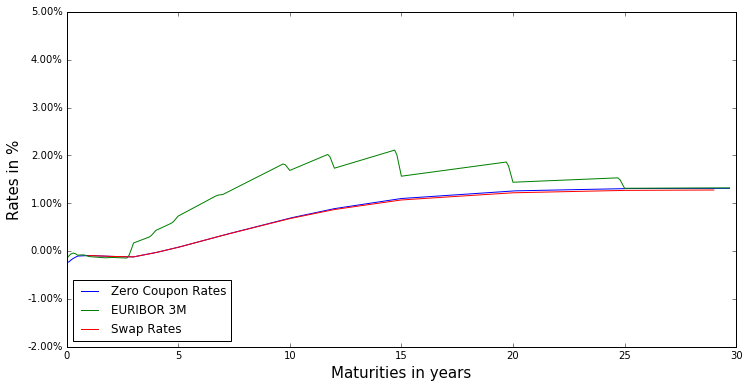

In [6]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

maturities = np.arange(0,29.75,0.1)
zcrates = [ curve.zcrate(2.0/365+mat) for mat in maturities]
euribor3M = [ curve.fwd(2.0/365+mat,2.0/365+mat+0.25) for mat in maturities]
maturities_swaps = np.arange(1,30,1)
swaps = [ curve.Swap(mat) for mat in maturities_swaps]

fig, ax = plt.subplots(figsize=(12,6))

ax.plot(maturities,zcrates,label="Zero Coupon Rates")
ax.plot(maturities,euribor3M,label="EURIBOR 3M")
ax.plot(maturities_swaps,swaps,label="Swap Rates")

ax.set_xlabel('Maturities in years')
ax.set_ylabel('Rates in %')
ax.xaxis.label.set_fontsize(15)
ax.yaxis.label.set_fontsize(15)

def myfunc(x, pos=0):
     return '%1.2f%%'%(100*x)

ax.yaxis.set_major_formatter(FuncFormatter(myfunc))

ax.set_autoscaley_on(False)
ax.set_ylim([-0.02,0.05])

legend = ax.legend(loc='lower left')

plt.show()

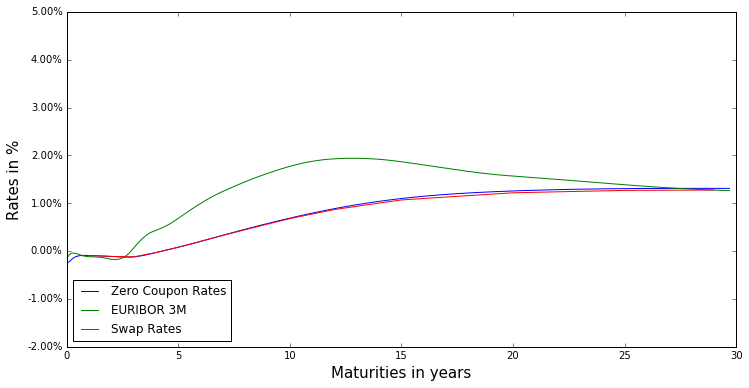

In [7]:
import matplotlib.pyplot as plt

maturities = np.arange(0,29.75,0.1)
zcrates = [ curvespline.zcrate(2.0/365+mat) for mat in maturities]
euribor3M = [ curvespline.fwd(2.0/365+mat,2.0/365+mat+0.25) for mat in maturities]
maturities_swaps = np.arange(1,30,1)
swaps = [ curve.Swap(mat) for mat in maturities_swaps]

fig, ax = plt.subplots(figsize=(12,6))

ax.plot(maturities,zcrates,label="Zero Coupon Rates")
ax.plot(maturities,euribor3M,label="EURIBOR 3M")
ax.plot(maturities_swaps,swaps,label="Swap Rates")

ax.set_xlabel('Maturities in years')
ax.set_ylabel('Rates in %')
ax.xaxis.label.set_fontsize(15)
ax.yaxis.label.set_fontsize(15)

def myfunc(x, pos=0):
     return '%1.2f%%'%(100*x)

ax.yaxis.set_major_formatter(FuncFormatter(myfunc))

ax.set_autoscaley_on(False)
ax.set_ylim([-0.02,0.05])

legend = ax.legend(loc='lower left')

plt.show()

On peut induire quotes **"implictes"** des Futures.

In [8]:
Futures = ['MAR16','JUN16','SEP16','DEC16','MAR17','JUN17','SEP17','DEC17']

([(f,round(curve.Quote(f),2)) for f in Futures],
[(f,round(curvespline.Quote(f),2)) for f in Futures])

([('MAR16', 100.09),
  ('JUN16', 100.05),
  ('SEP16', 100.08),
  ('DEC16', 100.09),
  ('MAR17', 100.12),
  ('JUN17', 100.13),
  ('SEP17', 100.14),
  ('DEC17', 100.14)],
 [('MAR16', 100.07),
  ('JUN16', 100.05),
  ('SEP16', 100.08),
  ('DEC16', 100.11),
  ('MAR17', 100.12),
  ('JUN17', 100.12),
  ('SEP17', 100.14),
  ('DEC17', 100.16)])

Valorisation et couverture
====



In [9]:
import copy

class Swap:
    def __init__(self,startDate,maturity,K,nominal,payrcv):
        self.startDate = startDate
        self.maturity = maturity
        self.K = K
        self.nominal = nominal
        self.payrcv = payrcv
        
    def price(self,curve):
        lag = float((self.startDate-curve.asofdate).days)/365.0
        price = 0
        schedule = np.arange(0,float(self.maturity)+1,1)
        schedule += lag
        schedule = [d for d in schedule if d >= 0]
        if lag < 0:
            schedule = np.insert(schedule,0,0)
        
        for i in range(len(schedule)-1):
            flowstartdate = 2.0/365+schedule[i]
            flowenddate = 2.0/365+schedule[i+1]
            price = price + self.K*self.nominal*curve.df(flowenddate)*(flowenddate-flowstartdate)-self.nominal*curve.df(flowstartdate)+self.nominal*curve.df(flowenddate)

        return self.payrcv*price

def BumpCurve(curve,plot,bumpValue):
    quotes = { plot:curve.Quote(plot) for plot in curve.plots }
    quotes[plot] += bumpValue
    quote_rates = [(plot,quotes[plot]) for plot in curve.plots]
    ret = copy.copy(curve)
    ret.t = []
    ret.rates = []
    ret.plots = []
    ret.Calibrate(quote_rates)
    return ret

def Hedge(swap,curve, bumpValue = 0.0001):
    curr_curve = curve
    prev_price = swap.price(curr_curve)
    ret = []
    totalsensi = 0
    totalnominal = 0
    
    for p in curve.plots:
        curr_curve = BumpCurve(curr_curve,p,bumpValue)
        curr_price = swap.price(curr_curve)
        curr_plot_sensi = curr_curve.Price(p,curve.Quote(p))-curve.Price(p,curve.Quote(p))
        ret += [(p,round(curr_price-prev_price),round((curr_price-prev_price)/curr_plot_sensi))]
        totalsensi+=curr_price-prev_price;
        totalnominal+=(curr_price-prev_price)/curr_plot_sensi;
        prev_price = curr_price
        
    ret += [("TOTAL",round(totalsensi),round(totalnominal))]
    
    return ret

La classe **Swap** permet de valoriser un swap de maturité (qui a été traité dans le passé) et de taux fixe quelconque.

In [10]:
from numpy import arange
def displayhedge(hedge):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
    
    plotpos = arange(len(hedge))+.5
    plotnames = [ h[0] for h in hedge]
    sensis = [ h[1] for h in hedge]
    notionals = [ h[2] for h in hedge]
    
    # Sensibilités
    
    ax[0].barh(plotpos,sensis,align="center")
    ax[0].set(yticks=plotpos, yticklabels=plotnames, xlim=[-150000, 150000])
    
    def sensifunc(x, pos=0):
         return '%1.0f'%(x/1000)
    ax[0].xaxis.set_major_formatter(FuncFormatter(sensifunc))
    
    ax[0].set_xlabel(u'Sensibilités (kEUR/bp)')
    ax[0].xaxis.label.set_fontsize(15)
    
    
    for p, s in zip(plotpos,sensis) :
        if s>0:
            pos_x =-80000
        else:
            pos_x =80000
            
        if abs(s)>5000:
            ax[0].annotate('%1.0f KEUR/bp'%(s/1000),xy=(pos_x,p), va='center',size=10, weight='bold')
    
    
    ax[1].barh(plotpos,notionals,align="center")
    ax[1].set(yticks=plotpos, yticklabels=plotnames, xlim=[-200000000, 200000000])
    
    # Nominal
    
    def notfunc(x, pos=0):
         return '%1.0f'%(x/1000000)
    ax[1].xaxis.set_major_formatter(FuncFormatter(notfunc))
    
    ax[1].set_xlabel(u'Ratios de couverture (Mios EUR)')
    ax[1].xaxis.label.set_fontsize(15)
    
    for p, n in zip(plotpos,notionals) :
        if n>0:
            pos_x =-110000000
        else:
            pos_x =110000000
        if abs(n)>5000000:
            ax[1].annotate('%1.0f Mios EUR'%(n/1000000),xy=(pos_x,p), va='center',size=10, weight='bold')
    
    plt.show()

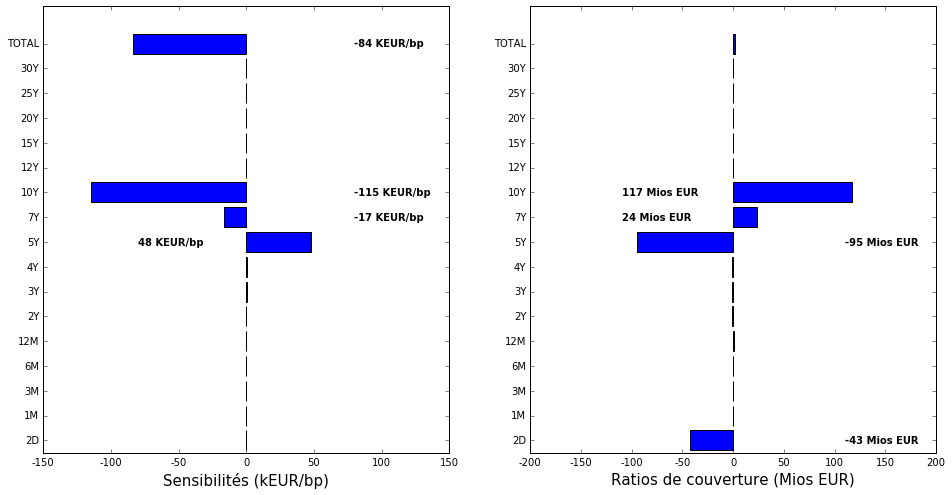

In [25]:
swap = Swap(date(2021,1,29),5,curve.Quote("5Y")+0.1,100000000,1)
hedge = Hedge(swap,curve)
displayhedge(hedge)